In [1]:
# pip install awswrangler

In [2]:
# pip install spacy

In [3]:
#!python -m spacy download pt

In [4]:
# pip install spacy && python -m spacy download pt_core_news_sm

In [5]:
import re
import os
import sys
import spacy
import random
import numpy as np
import pandas as pd
import awswrangler as wr
from spacy.training import Example
from spacy.util import minibatch, compounding

sys.path.append(os.path.dirname(os.getcwd())+'/src')
from preprocess import preprocess_module

---

### Reading processed data for training

In [6]:
bucket = 'ons-ds-dev-entityrecognition'
path = 'mpo/mvp/data/processed/inequality_samples.parquet'
train_dataset = wr.s3.read_parquet(f's3://{bucket}/{path}') #pd.read_parquet(os.path.dirname(os.getcwd())+'/data/dataset_0.parquet')
train_dataset.sort_values(by=['text','start', 'end'], inplace=True)

In [7]:
train_dataset[['start','end']] = train_dataset[['start','end']].astype('int')

In [8]:
train_dataset.head()

,text,entity,label,start,end
331,1 . Desenergização iniciando pela SE Biguaçu ...,tensão na SE Gaspar 2 inferior a 239 kV,INEQUACAO,261,300
330,1 . Desenergização iniciando pela SE Biguaçu ...,SE Gaspar 2 inferior a 239 kV,INEQUACAO,271,300
56,1 . Desenergização iniciando pela SE Cachoeir...,SE Taubaté 500 kV ≤ 549 kV,INEQUACAO,417,443
57,1 . Desenergização iniciando pela SE Cachoeir...,SE Taubaté 500 kV ≤ 547 kV,INEQUACAO,587,613
58,1 . Desenergização iniciando pela SE Cachoeir...,SE Taubaté 500 kV ≤ 546 kV,INEQUACAO,709,735


In [9]:
# train_dataset[train_dataset['text']==train_dataset['text'].iloc[0]]

---

### Feature Engineering

In [10]:
training_set = []
unique_text = sorted(set(train_dataset['text']))
for samp in unique_text:
    df_loop = train_dataset[train_dataset['text']==samp]
    df_loop.drop_duplicates(inplace=True)
    df_loop.sort_values(by=['start','end'], axis=0, ascending=True, inplace=True)
    sliding_ref = -1
    ent_list = []
    for index, row in df_loop.iterrows():
        if row['start'] > sliding_ref:
            ent_list.append([row['start'], row['end'], row['label']])
            sliding_ref = row['end']
    training_set.append([samp, {'entities': tuple(ent_list)}])

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [11]:
training_set[0]

[' 1 . Desenergização iniciando pela SE Biguaçu ( Sentido Único ) PassoCoordenaçãoControleComando / ExecuçãoProcedimentoObjetivo / Item de Controle 1COSR-SCOSR-SCGT ELETROSULDesligar , na SE Biguaçu , a LT 230 kV Biguaçu / Gaspar 2 . Todos os períodos de carga : tensão na SE Gaspar 2 inferior a 239 kV . 2COSR-SCOSR-SCGT ELETROSULDesenergizar , na SE Gaspar 2 , a LT 230 kV Biguaçu / Gaspar 2 . ',
 {'entities': ([261, 300, 'INEQUACAO'],)}]

In [12]:
# train_dataset[train_dataset['text']==train_dataset['text'].iloc[0]]

---

### Model initialization

In [42]:
# loading spacy pt-br dependencies - training with preset
nlp = spacy.load("pt_core_news_sm")
optimizer = nlp.create_optimizer()

# alternative - start blank model
# nlp = spacy.blank('pt')
# optimizer = nlp.begin_training()

# if NER not in pipeline modules within spacy, download it
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

# printing pipelines
nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'lemmatizer', 'attribute_ruler', 'ner']

In [43]:
texto = 'Olá, bom dia. Hoje fui ao Carrefour e comprei uma televisão.'
doc = nlp(texto)
print([(entity, entity.label_) for entity in doc.ents])

[(Carrefour, 'ORG')]


### Adding custom labels to blank spacy model

In [44]:
# adding labels to spacy NER module
for label in set(train_dataset['label'].to_list()):
    ner.add_label(label)

#spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)
ner.labels

('INEQUACAO', 'LOC', 'MISC', 'ORG', 'PER')

In [45]:
import warnings
warnings.simplefilter("ignore")
n_iterations = 20
batch_size = 30
loss_list = []
pipes_except_ner = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

# only training NER module - no other module can be retrained in this section
with nlp.disable_pipes(*pipes_except_ner):
    for it in range(n_iterations):
        random.shuffle(training_set)
        losses = {}       
        batches = minibatch(
            training_set,
            size=batch_size
            )
        for batch in batches:
            texts, annotations = zip(*batch)
            for text, annot in zip(texts, annotations):
                doc = nlp.make_doc(text)
                example = Example.from_dict(doc, annot)
                #spacy.training.offsets_to_biluo_tags(doc, annot['entities'])
                nlp.update(
                    [example],
                    sgd=optimizer, 
                    drop=0.30, 
                    losses=losses
                    )
        print('iterations: ', it+1, 'Loss: ', losses)
        loss_list.append(losses['ner'])

iterations:  1 Loss:  {'ner': 1634.804493885034}
iterations:  2 Loss:  {'ner': 213.3340974128402}
iterations:  3 Loss:  {'ner': 90.88965525176535}
iterations:  4 Loss:  {'ner': 182.00396905998844}
iterations:  5 Loss:  {'ner': 83.53795162265367}
iterations:  6 Loss:  {'ner': 83.51287262942745}
iterations:  7 Loss:  {'ner': 59.54584050714286}
iterations:  8 Loss:  {'ner': 63.58214283052588}
iterations:  9 Loss:  {'ner': 85.94864023936256}
iterations:  10 Loss:  {'ner': 74.97133138601802}
iterations:  11 Loss:  {'ner': 87.8462128355446}
iterations:  12 Loss:  {'ner': 47.7574962268493}
iterations:  13 Loss:  {'ner': 63.64518468770076}
iterations:  14 Loss:  {'ner': 93.70272307817457}
iterations:  15 Loss:  {'ner': 180.4355483798839}
iterations:  16 Loss:  {'ner': 40.06420261926083}
iterations:  17 Loss:  {'ner': 37.34368752260705}
iterations:  18 Loss:  {'ner': 57.60132942326628}
iterations:  19 Loss:  {'ner': 46.883298265852495}
iterations:  20 Loss:  {'ner': 52.256014113639495}


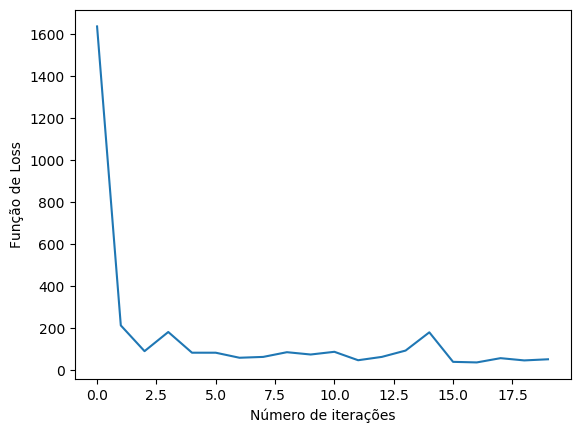

In [47]:
# loss plot
import matplotlib.pyplot as plt
plt.plot(range(n_iterations), loss_list)
plt.xlabel('Número de iterações')
plt.ylabel('Função de Loss')
plt.show()

In [69]:
# running entity recognition in dataset
recognition_dict = {
    'entity':[],
    'type':[]
}

text = training_set[60][0]
print(text)
doc = nlp(text)
for i in range(len(doc.ents)):
    recognition_dict['entity'].append(str(doc.ents[i]))
    recognition_dict['type'].append(doc.ents[i].label_)
    
recognition_dict

 1 . Energização iniciando pela SE Blumenau ( Sentido Normal ) PassoCoordenaçãoControleComando / ExecuçãoProcedimentoObjetivo / Item de ControleA energização desta LT , com autonomia pelo agente , somente é realizada em caso de desligamento automático , quando não ocorreu desligamento total da SE Blumenau e se as condições especificadas na IO-OI . S . BLU estiverem atendidas . Nas demais situações , a energização será coordenada pelo COSR-S , conforme procedimentos a seguir : 1COSR-SCOSR-SCGT ELETROSULEnergizar a LT 230 kV Blumenau / Gaspar 2 C1 ( ou C2 ), pela SE Blumenau . Opção 1 ( condição de autonomia do agente ): Não ter ocorrido desligamento total da SE BlumenauTensão na SE Blumenauigual ou inferior a 242 kVFluxo de potência ativa na LT 525 kV Blumenau / Curitiba , na LT 525 Blumenau / Campos Novos , e em pelo menos um dos transformadores 525/230/13 , 8 kV da SE Blumenau . Opção 2 : Estar fechada a Área Itá com a Área Gov . Ney Aminthas de Barros Braga , conforme IO-RR . STensão

{'entity': ['STensão na SE Blumenauigual ou inferior a 242 kVFluxo',
  'Tensão na SE Gaspar 2igual ou inferior a 240 kVFluxo',
  'Tensão na SE Gaspar 2igual ou inferior a 240 kVFluxo'],
 'type': ['INEQUACAO', 'INEQUACAO', 'INEQUACAO']}

In [32]:
import shutil
from datetime import datetime
model_id = 'entity-recognition-model-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
shutil.make_archive(model_id, 'zip', 'model')

'/root/ons-mvp-entity-recognition/notebooks/entity-recognition-model-2022-08-29-18-07-02.zip'

In [35]:
import boto3
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file(f'{model_id}.zip', f'mpo/mvp/artifacts/model/{model_id}.zip')

In [33]:
nlp.to_disk('../artifacts/spacy_inequalities')

### Metrics

In [27]:
from spacy.scorer import Scorer

In [28]:
examples = []
scorer = Scorer()
for text, annotations in training_set:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    example.predicted = nlp(str(example.predicted))
    examples.append(example)

score_result_se = scorer.score(examples)

In [29]:
metrics = score_result_se['ents_per_type']
metrics

{'INEQUACAO': {'p': 0.7555555555555555,
  'r': 0.7727272727272727,
  'f': 0.7640449438202247}}

In [30]:
metrics = pd.DataFrame(score_result_se['ents_per_type'])
metrics.head()

,INEQUACAO
f,0.764045
p,0.755556
r,0.772727


In [41]:
metrics_original = {
  'SUBESTACAO': {'p': 0.9888810030754672,
  'r': 0.9945277182964549,
  'f': 0.9916963226571769},
 'EQUIPAMENTO': {'p': 0.9928905843592856,
  'r': 0.9939246658566221,
  'f': 0.9934073560027759},
 'VALOR_COM_UNID.MEDIDA': {'p': 0.9136636636636637,
  'r': 0.9008142116950407,
  'f': 0.9071934401789042},
 'USINA': {'p': 0.9887640449438202,
  'r': 0.9723756906077348,
  'f': 0.9805013927576601},
 'ACAO_MANUAL': {'p': 0.8617672790901137,
  'r': 0.9889558232931727,
  'f': 0.9209911173445535},
 'OPERADOR_MATEMATICO': {'p': 0.8926174496644296,
  'r': 0.9833641404805915,
  'f': 0.9357959542656112},
 'ESTADO_OPERATIVO': {'p': 0.8351145038167939,
  'r': 0.988256549232159,
  'f': 0.9052544476623914}}

metrics_original

{'SUBESTACAO': {'p': 0.9888810030754672,
  'r': 0.9945277182964549,
  'f': 0.9916963226571769},
 'EQUIPAMENTO': {'p': 0.9928905843592856,
  'r': 0.9939246658566221,
  'f': 0.9934073560027759},
 'VALOR_COM_UNID.MEDIDA': {'p': 0.9136636636636637,
  'r': 0.9008142116950407,
  'f': 0.9071934401789042},
 'USINA': {'p': 0.9887640449438202,
  'r': 0.9723756906077348,
  'f': 0.9805013927576601},
 'ACAO_MANUAL': {'p': 0.8617672790901137,
  'r': 0.9889558232931727,
  'f': 0.9209911173445535},
 'OPERADOR_MATEMATICO': {'p': 0.8926174496644296,
  'r': 0.9833641404805915,
  'f': 0.9357959542656112},
 'ESTADO_OPERATIVO': {'p': 0.8351145038167939,
  'r': 0.988256549232159,
  'f': 0.9052544476623914}}

In [44]:
metrics_original.update(score_result_se['ents_per_type'])

In [45]:
metrics_original

{'SUBESTACAO': {'p': 0.9888810030754672,
  'r': 0.9945277182964549,
  'f': 0.9916963226571769},
 'EQUIPAMENTO': {'p': 0.9928905843592856,
  'r': 0.9939246658566221,
  'f': 0.9934073560027759},
 'VALOR_COM_UNID.MEDIDA': {'p': 0.9136636636636637,
  'r': 0.9008142116950407,
  'f': 0.9071934401789042},
 'USINA': {'p': 0.9887640449438202,
  'r': 0.9723756906077348,
  'f': 0.9805013927576601},
 'ACAO_MANUAL': {'p': 0.8617672790901137,
  'r': 0.9889558232931727,
  'f': 0.9209911173445535},
 'OPERADOR_MATEMATICO': {'p': 0.8926174496644296,
  'r': 0.9833641404805915,
  'f': 0.9357959542656112},
 'ESTADO_OPERATIVO': {'p': 0.8351145038167939,
  'r': 0.988256549232159,
  'f': 0.9052544476623914},
 'INEQUACAO': {'p': 0.6770833333333334,
  'r': 0.7386363636363636,
  'f': 0.7065217391304348}}

In [47]:
# metrics_original = pd.DataFrame(metrics_original.mean(axis=1), columns=['metrics']).transpose()
# metrics_original['variant'] = model_id
# metrics_original

,p,r,f,variant
metrics,0.924814,0.974603,0.947834,entity-recognition-model-2022-08-29-18-07-02


In [52]:
bucket = 'ons-ds-dev-entityrecognition'
path = 'mpo/mvp/artifacts/model_info/metrics.parquet'
obj_uri = f's3://{bucket}/{path}'
metrics_original.to_parquet(obj_uri, compression='gzip')

In [73]:
def insert_new_metric(
    metrics_dict:dict,
    bucket:str='ons-ds-dev-entityrecognition',
    path:str='mpo/mvp/artifacts/model_info/metrics.parquet',
    model_id:str='model-default'
    ):
    
    metrics = pd.DataFrame(metrics_dict)
    metrics = pd.DataFrame(metrics.mean(axis=1), columns=['metrics']).transpose()
    metrics['variant'] = model_id
    obj_uri = f's3://{bucket}/{path}'
    
    try:
        s3_metrics = pd.read_parquet(obj_uri)
        s3_metrics = pd.concat([s3_metrics, metrics], axis=0)
    except:
        s3_metrics = metrics
    
    s3_metrics.drop_duplicates(keep='first', inplace=True)
    s3_metrics.sort_values(by=['variant'], inplace=True)
    s3_metrics.to_parquet(obj_uri)
    
    return s3_metrics

In [74]:
full_metrics = insert_new_metric(metrics_original, model_id = 'entity-recognition-model-2022-08-24-19-27-40')

In [75]:
full_metrics

,p,r,f,variant
metrics,0.924814,0.974603,0.947834,entity-recognition-model-2022-08-24-19-27-40
metrics,0.880204,0.902734,0.886447,entity-recognition-model-2022-08-29-18-07-02


In [76]:
def load_metrics_from_s3(
    bucket:str='ons-ds-dev-entityrecognition',
    path:str='mpo/mvp/artifacts/model_info/metrics.parquet'
    ):
    
    obj_uri = f's3://{bucket}/{path}'
    metrics = pd.read_parquet(obj_uri)
    return metrics

In [77]:
metrics_df = load_metrics_from_s3()
metrics_df

,p,r,f,variant
metrics,0.924814,0.974603,0.947834,entity-recognition-model-2022-08-24-19-27-40
metrics,0.880204,0.902734,0.886447,entity-recognition-model-2022-08-29-18-07-02


In [78]:
print(f'Initialized training sequence at {datetime.now()}')

Initialized training sequence at 2022-08-29 19:39:15.135911


In [63]:
full_metrics = insert_new_metric(metrics, model_id = 'entity-recognition-model-2022-08-29-18-07-02')

In [68]:
bucket = 'ons-ds-dev-entityrecognition'
path = 'mpo/mvp/artifacts/model_info/metrics.parquet'
obj_uri = f's3://{bucket}/{path}'

full_metrics_temp = full_metrics.iloc[[0,2]]
full_metrics_temp.to_parquet()

b'PAR1\x15\x04\x15 \x15$L\x15\x04\x15\x04\x12\x00\x00\x10<\x08 \'\xb0\x13\x98\xed?a}\xde(\xa1*\xec?\x15\x00\x15\x12\x15\x16,\x15\x04\x15\x04\x15\x06\x15\x06\x1c\x18\x08\x08 \'\xb0\x13\x98\xed?\x18\x08a}\xde(\xa1*\xec?\x16\x00(\x08\x08 \'\xb0\x13\x98\xed?\x18\x08a}\xde(\xa1*\xec?\x00\x00\x00\t \x02\x00\x00\x00\x04\x01\x01\x03\x02&\xd8\x01\x1c\x15\n\x195\x04\x00\x06\x19\x18\x01p\x15\x02\x16\x04\x16\xc8\x01\x16\xd0\x01&H&\x08\x1c\x18\x08\x08 \'\xb0\x13\x98\xed?\x18\x08a}\xde(\xa1*\xec?\x16\x00(\x08\x08 \'\xb0\x13\x98\xed?\x18\x08a}\xde(\xa1*\xec?\x00\x19,\x15\x04\x15\x04\x15\x02\x00\x15\x00\x15\x04\x15\x02\x00\x00\x00\x15\x04\x15 \x15$L\x15\x04\x15\x04\x12\x00\x00\x10< \x01\xad\xf8\xf1/\xef?P\x86"\xbb1\xe3\xec?\x15\x00\x15\x12\x15\x16,\x15\x04\x15\x04\x15\x06\x15\x06\x1c\x18\x08 \x01\xad\xf8\xf1/\xef?\x18\x08P\x86"\xbb1\xe3\xec?\x16\x00(\x08 \x01\xad\xf8\xf1/\xef?\x18\x08P\x86"\xbb1\xe3\xec?\x00\x00\x00\t \x02\x00\x00\x00\x04\x01\x01\x03\x02&\xde\x04\x1c\x15\n\x195\x04\x00\x06\x19\x18\x01

In [69]:
metrics_df = pd.read_parquet(obj_uri)
metrics_df

,p,r,f,variant
metrics,0.924814,0.974603,0.947834,entity-recognition-model-2022-08-24-19-27-40
metrics,0.924814,0.974603,0.947834,entity-recognition-model-2022-08-29-18-07-02
metrics,0.880204,0.902734,0.886447,entity-recognition-model-2022-08-29-18-07-02


In [66]:
full_metrics_temp

0.9478342901241533

In [44]:
metrics = pd.DataFrame(metrics.mean(axis=1), columns=['metrics']).transpose()
metrics['variant'] = 'entity-recognition-2022-08-24-19-27-40'
metrics

,p,r,f,variant
metrics,0.880204,0.902734,0.886447,entity-recognition-model-2022-08-29-18-07-02


In [26]:
from datetime import datetime
timehash = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
timehash

'2022-08-24-19-27-40'

In [27]:
bucket = 'ons-ds-dev-entityrecognition'
file_path = f'mpo/mvp/data/output/metrics-{timehash}.parquet'
s3_uri = f's3://{bucket}/{file_path}'
metrics.to_parquet(s3_uri)